In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import json
import nltk
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
df = pd.read_csv('data/final_data.csv')

In [39]:
df.shape

(100000, 10)

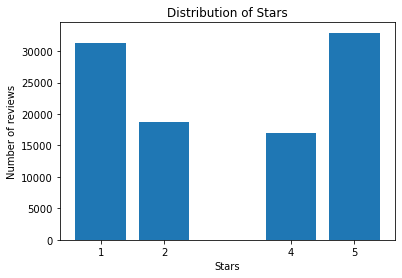

In [41]:
# The Stars distribution 
values, counts = np.unique(df['stars'], return_counts=True)

plt.figure()
plt.bar(values, counts, tick_label=['1','2','4','5'])
plt.title('Distribution of Stars')
plt.xlabel('Stars')
plt.ylabel('Number of reviews')
plt.show()

In [42]:
# Create new column "Target" that stored 0's or 1's. 0 being Negative, 1 being Positive
df["Target"] = np.where(df["stars"] >= 4, 1, 0)
df.head(3)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,Target
0,0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16,0
1,1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52,0
2,2,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,0


In [43]:
# Picking the only text and target column
df_final = df[['text','Target']]
df_final

,text,Target
0,"As someone who has worked with many museums, I...",0
1,I am actually horrified this place is still in...,0
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0
3,"If I could give less than one star, that would...",0
4,10pm on a super bowl Sunday and they're alread...,0
...,...,...
99995,I'm not a mani/pedi person. I went with my aun...,1
99996,I've written maybe one other review in my enti...,1
99997,My boyfriend buys me one at least once a month...,1
99998,Dr. Lee and staff are top notch! Very efficien...,1


In [44]:
import re 
def function_clean(text):
    text = re.sub(r"http\S+", "", text) #removing the URL Http
    # Removal of mentions
    text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   
    return text

In [45]:
# applying the cleaning function to text column
df_final['text'] = df_final['text'].apply(lambda text: function_clean(text))

In [46]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_final["text"]
y = df_final["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [47]:
y.value_counts()

1    50000
0    50000
Name: Target, dtype: int64

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [49]:
import string
#nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    listof_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            for punctuation_mark in string.punctuation:
                word = word.replace(punctuation_mark, '').lower()
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer


vect_1 = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words={'english'}, ngram_range=(1,3)).fit(X_train)

X_train1 = vect_1.transform(X_train)
X_test1 = vect_1.transform(X_test)

In [59]:
#counting most repetitive words 
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vect_1.get_feature_names())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)



,word,count
1966,food,2310.008738
4054,place,2058.430759
2412,great,1929.061689
2318,good,1910.801663
4809,service,1819.912651
5542,time,1509.335826
3113,like,1472.305078
2181,get,1456.556882
355,back,1431.844515
3760,one,1420.229538


Modeling:  First Model - Logistic Regression

In [53]:
# fitting a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Fitting Logistic regression to the training set
logreg = LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1)
logreg.fit(X_train1, y_train)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

Score on training set: 0.95225
Score on test set: 0.94265


In [17]:
from sklearn.metrics import classification_report
print('The Confusion Matrix')
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
display(df_cm_lr)
print('The Classification report')
report = classification_report(y_test, y_pred_logreg, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

The Confusion Matrix


,Predicted 0,Predicted 1
True 0,9374,560
True 1,587,9479


The Classification report


,precision,recall,f1-score,support
0,0.941070,0.943628,0.942347,9934.00000
1,0.944218,0.941685,0.942950,10066.00000
accuracy,0.942650,0.942650,0.942650,0.94265
macro avg,0.942644,0.942656,0.942648,20000.00000
weighted avg,0.942654,0.942650,0.942650,20000.00000


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('classifier',LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1))]
pipe = Pipeline(estimators)

params = {'classifier__C' : [10**j for j in range(-4,4)]}
grid_search = GridSearchCV(pipe, param_grid=params,cv=5)

In [19]:
fitted_search = grid_search.fit(X_train1, y_train)

In [20]:
fitted_search.best_estimator_

Pipeline(steps=[('classifier', LogisticRegression(C=10, random_state=1))])

In [21]:
logreg = LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False)
logreg.fit(X_train1, y_train)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

# Creating confusion matrix/ dataFrame
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_lr

Score on training set: 0.9647125
Score on test set: 0.945


,Predicted 0,Predicted 1
True 0,9373,561
True 1,539,9527


Using A Different Model:  Random Forest Classifier Model

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

my_random_forest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [5, 50],
    'criterion' :['gini', 'entropy']
}


In [23]:
CV_rfc = GridSearchCV(estimator=my_random_forest, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train1, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [5, 50]})

In [24]:
CV_rfc.best_params_

{'criterion': 'gini', 'n_estimators': 50}

In [25]:
rfc1 = RandomForestClassifier(random_state=42, n_estimators= 50, criterion='gini')

In [26]:
rfc1.fit(X_train1, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [27]:
pred = rfc1.predict(X_test1)

In [28]:

print(f"Random Forest training: {rfc1.score(X_train1, y_train)}")
print(f"Random Forest test: {rfc1.score(X_test1, y_test)}")

Random Forest training: 0.9998875
Random Forest test: 0.90635


In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
# Creating confusion matrix/ dataFrame
con_mat_RF = confusion_matrix(y_test, pred)
df_cm_RF = pd.DataFrame(con_mat_RF, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_RF

,Predicted 0,Predicted 1
True 0,9062,872
True 1,1001,9065


In [31]:
input_string = "the wait was too long, but worth the wait"
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",rfc1.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: the wait was too long, but worth the wait
Logistic Regression model: [1]
Random Forest model      : [0]


In [32]:
input_string = "I thought it would be great, but it was still good."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",rfc1.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: I thought it would be great, but it was still good.
Logistic Regression model: [0]
Random Forest model      : [1]


Save the Regression and Random Forest Models to use in Flask

In [57]:
import pickle

pickle.dump(vect_1, open("vectorizer.pickle", "wb"))
pickle.dump(rfc1, open("rfc_model.sav", 'wb'))
pickle.dump(logreg, open("regression.sav", 'wb'))